In [134]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv('interview-dataset.csv', parse_dates = [4], infer_datetime_format = True)
data.head()

,Unnamed: 0,vendor_code,city_id,gfv_local,order_placed_at,realized_prep_time,queued_orders,items_count,vertical_type
0,593038,s8tt,10,133.0,2020-10-04 14:13:12,8.333333,1,2,restaurants
1,143603,s9bg,10,115.0,2020-09-09 20:12:12,21.316667,2,3,restaurants
2,12731,s1ut,10,236.0,2020-08-27 17:05:01,18.150000,5,5,restaurants
3,790385,s4dc,10,266.0,2020-09-17 12:12:52,10.000000,0,4,restaurants
4,173947,s1ut,10,203.0,2020-09-12 11:46:21,11.733333,3,3,restaurants


### Data analysis 

In [5]:
#data distribution for each vendor
data.groupby('vendor_code')['city_id'].count()

vendor_code
s0hv     962
s0mg    2678
s1fo    1398
s1nr    1008
s1oz    1744
s1ut    2489
s2ds    1776
s2tu     972
s3aj    2053
s4dc    1483
s5fu    1911
s6bs    1003
s6li    1336
s7lu    1366
s7ly     936
s8ld    1154
s8tt     990
s9bg    1572
s9fk    1403
v7kr    1766
Name: city_id, dtype: int64

In [6]:
#median preparation time for each vendor
data.groupby('vendor_code')['realized_prep_time'].median()

vendor_code
s0hv    15.708333
s0mg    10.000000
s1fo     9.000000
s1nr    17.000000
s1oz    15.000000
s1ut    13.150000
s2ds    15.000000
s2tu     8.000000
s3aj    11.000000
s4dc    10.000000
s5fu    11.000000
s6bs    10.000000
s6li    15.000000
s7lu    14.000000
s7ly    12.583333
s8ld    10.000000
s8tt    10.000000
s9bg    10.000000
s9fk    11.850000
v7kr    15.000000
Name: realized_prep_time, dtype: float64

/Users/dhanuvardhan/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'histogram of prep time')

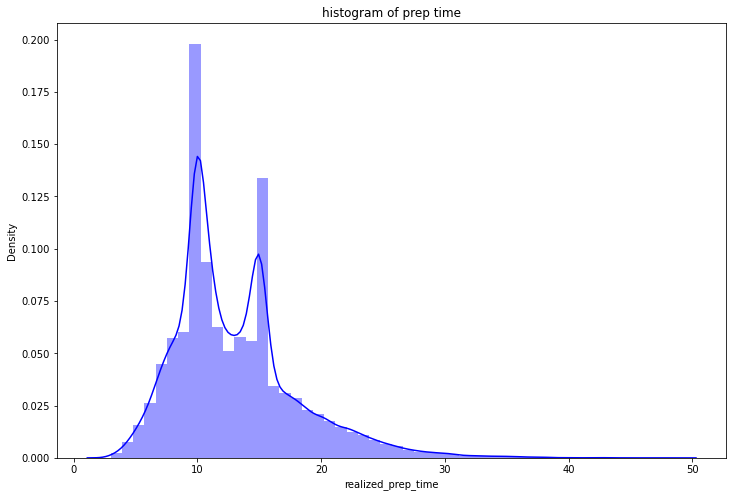

In [130]:
plt.figure(figsize = (12,8))
sns.distplot(data['realized_prep_time'], kde =True, hist = True, color = 'blue')
plt.title('histogram of prep time')

In [12]:
#relation of queued order with meal prep time for each vendor
print(data.groupby(['vendor_code', 'queued_orders'])['realized_prep_time'].mean())

vendor_code  queued_orders
s0hv         0                14.675000
             1                14.883491
             2                15.307760
             3                16.588046
             4                16.334280
             5                17.351724
             6                18.589394
             7                19.727273
             8                21.346154
             9                19.628571
             10               21.564286
             11               21.824359
             12               28.386111
             13               27.898485
             14               22.873810
             15               24.341667
             16               34.027778
             17               31.133333
             18               29.193750
             19               36.150000
s0mg         0                10.006243
             1                 9.777388
             2                 9.899798
             3                10.123219
             

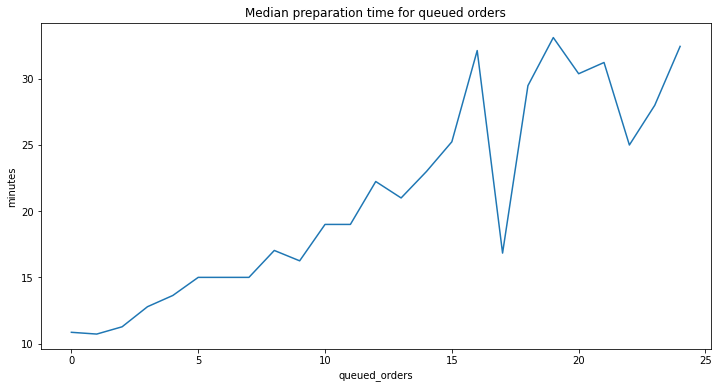

In [132]:
plt.figure(figsize = (12,6))
plt.title('Median preparation time for queued orders')
plt.ylabel('minutes')
plt.xlabel('queued_orders')
plt.plot(data.groupby('queued_orders')['realized_prep_time'].median())

In [11]:
pd.options.display.max_rows = 4000

In [14]:
#relation of items ordered with meal prep time for each vendor
print(data.groupby(['vendor_code', 'items_count'])['realized_prep_time'].mean())

vendor_code  items_count
s0hv         1              14.602261
             2              16.912396
             3              19.227686
             4              20.353825
             5              24.248077
             6              25.234167
             7              27.925000
             8              26.491667
             10             19.000000
             11             23.566667
             13             28.000000
s0mg         1              10.058738
             2               9.854312
             3              10.312920
             4               9.874306
             5              10.150362
             6               9.976911
             7               9.785156
             8               9.771429
             9              10.852778
             10             11.776852
             11             10.700000
             12              8.608333
             13             10.000000
             15             10.000000
             16          

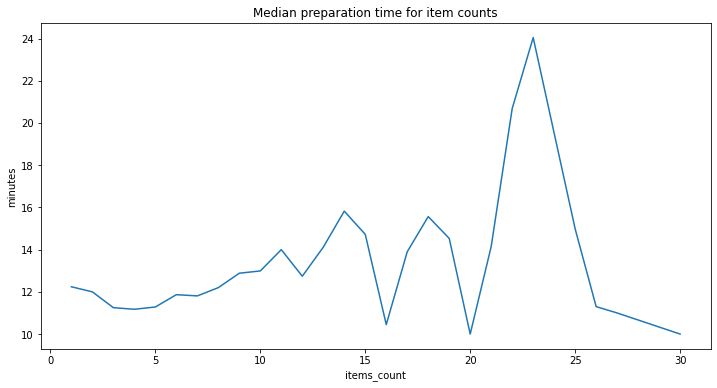

In [133]:
plt.figure(figsize = (12,6))
plt.title('Median preparation time for item counts')
plt.ylabel('minutes')
plt.xlabel('items_count')
plt.plot(data.groupby('items_count')['realized_prep_time'].median())

In [19]:
#looking for missing value columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          30000 non-null  int64  
 1   vendor_code         30000 non-null  object 
 2   city_id             30000 non-null  int64  
 3   gfv_local           30000 non-null  float64
 4   order_placed_at     30000 non-null  object 
 5   realized_prep_time  30000 non-null  float64
 6   queued_orders       30000 non-null  int64  
 7   items_count         30000 non-null  int64  
 8   vertical_type       30000 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 2.1+ MB


In [21]:
# Looking for relation of weekends with the meal prep time
day_convert = {0:'monday', 1:'tuesday', 2:'wed', 3: 'thursday', 4:'friday', 5:'saturday', 6:'sunday'}
data['day_ordered'] = data['order_placed_at'].apply(lambda x:day_convert[x.weekday()])
data.head()

,Unnamed: 0,vendor_code,city_id,gfv_local,order_placed_at,realized_prep_time,queued_orders,items_count,vertical_type,day_ordered
0,593038,s8tt,10,133.0,2020-10-04 14:13:12,8.333333,1,2,restaurants,sunday
1,143603,s9bg,10,115.0,2020-09-09 20:12:12,21.316667,2,3,restaurants,wed
2,12731,s1ut,10,236.0,2020-08-27 17:05:01,18.150000,5,5,restaurants,thursday
3,790385,s4dc,10,266.0,2020-09-17 12:12:52,10.000000,0,4,restaurants,thursday
4,173947,s1ut,10,203.0,2020-09-12 11:46:21,11.733333,3,3,restaurants,saturday


In [22]:
data.groupby(['vendor_code', 'day_ordered'])['realized_prep_time'].mean()

vendor_code  day_ordered
s0hv         friday         18.850912
             monday         15.574498
             saturday       17.843317
             sunday         16.703276
             thursday       16.344745
             tuesday        15.164835
             wed            15.503646
s0mg         friday         10.115195
             monday          9.488045
             saturday        9.993361
             sunday          9.821319
             thursday       10.892897
             tuesday        10.139571
             wed             9.857600
s1fo         friday         10.461376
             monday          9.274458
             saturday        9.578664
             sunday         11.299363
             thursday       10.120805
             tuesday         9.182346
             wed             9.848014
s1nr         friday         21.030041
             monday         16.108874
             saturday       18.855919
             sunday         16.806765
             thursday    

In [25]:
# Impact of weekend on number of orders
data.groupby(['vendor_code', 'day_ordered'])['city_id'].count()

vendor_code  day_ordered
s0hv         friday         201
             monday          83
             saturday       207
             sunday         173
             thursday       111
             tuesday         91
             wed             96
s0mg         friday         385
             monday         283
             saturday       477
             sunday         541
             thursday       359
             tuesday        326
             wed            307
s1fo         friday         189
             monday         169
             saturday       232
             sunday         314
             thursday       149
             tuesday        152
             wed            193
s1nr         friday         243
             monday          77
             saturday       214
             sunday         170
             thursday       106
             tuesday         81
             wed            117
s1oz         friday         296
             monday         178
             sa

In [40]:
#Creating peak lunch and dinner hours bucket and its impact on meal prep time
def peaktime(x):
    if(x.hour>=11 and x.hour<15):
        return 'lunch'
    elif(x.hour>=18 and x.hour<=21):
        return 'dinner'
    else:
        return 'non peak'
data['time_ordered'] = data['order_placed_at'].apply(peaktime)
data.head()

,Unnamed: 0,vendor_code,city_id,gfv_local,order_placed_at,realized_prep_time,queued_orders,items_count,vertical_type,day_ordered,time_ordered
0,593038,s8tt,10,133.0,2020-10-04 14:13:12,8.333333,1,2,restaurants,sunday,lunch
1,143603,s9bg,10,115.0,2020-09-09 20:12:12,21.316667,2,3,restaurants,wed,dinner
2,12731,s1ut,10,236.0,2020-08-27 17:05:01,18.150000,5,5,restaurants,thursday,non peak
3,790385,s4dc,10,266.0,2020-09-17 12:12:52,10.000000,0,4,restaurants,thursday,lunch
4,173947,s1ut,10,203.0,2020-09-12 11:46:21,11.733333,3,3,restaurants,saturday,lunch


In [41]:
data.groupby(['vendor_code', 'day_ordered', 'time_ordered'])['realized_prep_time'].median()

vendor_code  day_ordered  time_ordered
s0hv         friday       dinner          18.783333
                          lunch           13.000000
                          non peak        14.216667
             monday       dinner          15.683333
                          lunch           13.000000
                          non peak        14.916667
             saturday     dinner          17.908333
                          lunch           16.966667
                          non peak        14.150000
             sunday       dinner          17.000000
                          lunch           13.983333
                          non peak        15.000000
             thursday     dinner          15.916667
                          lunch           13.000000
                          non peak        13.408333
             tuesday      dinner          14.983333
                          lunch           12.441667
                          non peak        15.275000
             wed         

In [42]:
data.head()

,Unnamed: 0,vendor_code,city_id,gfv_local,order_placed_at,realized_prep_time,queued_orders,items_count,vertical_type,day_ordered,time_ordered
0,593038,s8tt,10,133.0,2020-10-04 14:13:12,8.333333,1,2,restaurants,sunday,lunch
1,143603,s9bg,10,115.0,2020-09-09 20:12:12,21.316667,2,3,restaurants,wed,dinner
2,12731,s1ut,10,236.0,2020-08-27 17:05:01,18.150000,5,5,restaurants,thursday,non peak
3,790385,s4dc,10,266.0,2020-09-17 12:12:52,10.000000,0,4,restaurants,thursday,lunch
4,173947,s1ut,10,203.0,2020-09-12 11:46:21,11.733333,3,3,restaurants,saturday,lunch


In [44]:
data_red = data.drop(columns = ['Unnamed: 0', 'city_id', 'order_placed_at', 'vertical_type'])
data_red.head()

,vendor_code,gfv_local,realized_prep_time,queued_orders,items_count,day_ordered,time_ordered
0,s8tt,133.0,8.333333,1,2,sunday,lunch
1,s9bg,115.0,21.316667,2,3,wed,dinner
2,s1ut,236.0,18.150000,5,5,thursday,non peak
3,s4dc,266.0,10.000000,0,4,thursday,lunch
4,s1ut,203.0,11.733333,3,3,saturday,lunch


In [47]:
#convert categorical features using one hot encoding
ohe = OneHotEncoder(sparse = False)
ohe_vendor_code = ohe.fit_transform(data_red['vendor_code'].values.reshape(-1,1))
ohe_df = pd.DataFrame(data=ohe_vendor_code, columns = list(ohe.categories_[0]))
df_combined= pd.concat([data_red, ohe_df], axis =1)
df_combined.head()

,vendor_code,gfv_local,realized_prep_time,queued_orders,items_count,day_ordered,time_ordered,s0hv,s0mg,s1fo,s1nr,s1oz,s1ut,s2ds,s2tu,s3aj,s4dc,s5fu,s6bs,s6li,s7lu,s7ly,s8ld,s8tt,s9bg,s9fk,v7kr
0,s8tt,133.0,8.333333,1,2,sunday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,s9bg,115.0,21.316667,2,3,wed,dinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,s1ut,236.0,18.150000,5,5,thursday,non peak,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,s4dc,266.0,10.000000,0,4,thursday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,s1ut,203.0,11.733333,3,3,saturday,lunch,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
ohe_day = ohe.fit_transform(df_combined['day_ordered'].values.reshape(-1,1))
ohe_day_df = pd.DataFrame(data= ohe_day, columns = list(ohe.categories_[0]))
df_comb = pd.concat([df_combined, ohe_day_df], axis =1)
df_comb.head()

,vendor_code,gfv_local,realized_prep_time,queued_orders,items_count,day_ordered,time_ordered,s0hv,s0mg,s1fo,s1nr,s1oz,s1ut,s2ds,s2tu,s3aj,s4dc,s5fu,s6bs,s6li,s7lu,s7ly,s8ld,s8tt,s9bg,s9fk,v7kr,friday,monday,saturday,sunday,thursday,tuesday,wed
0,s8tt,133.0,8.333333,1,2,sunday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,s9bg,115.0,21.316667,2,3,wed,dinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,s1ut,236.0,18.150000,5,5,thursday,non peak,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,s4dc,266.0,10.000000,0,4,thursday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,s1ut,203.0,11.733333,3,3,saturday,lunch,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
ohe_time = ohe.fit_transform(df_comb['time_ordered'].values.reshape(-1,1))
ohe_time_df = pd.DataFrame(data= ohe_time, columns = list(ohe.categories_[0]))
data_comb = pd.concat([df_comb, ohe_time_df], axis = 1)
data_comb.head()

,vendor_code,gfv_local,realized_prep_time,queued_orders,items_count,day_ordered,time_ordered,s0hv,s0mg,s1fo,s1nr,s1oz,s1ut,s2ds,s2tu,s3aj,s4dc,s5fu,s6bs,s6li,s7lu,s7ly,s8ld,s8tt,s9bg,s9fk,v7kr,friday,monday,saturday,sunday,thursday,tuesday,wed,dinner,lunch,non peak
0,s8tt,133.0,8.333333,1,2,sunday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,s9bg,115.0,21.316667,2,3,wed,dinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,s1ut,236.0,18.150000,5,5,thursday,non peak,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,s4dc,266.0,10.000000,0,4,thursday,lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,s1ut,203.0,11.733333,3,3,saturday,lunch,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [57]:
data_final = data_comb.drop(columns = ['day_ordered', 'time_ordered', 'vendor_code'])
data_final.head()

,gfv_local,realized_prep_time,queued_orders,items_count,s0hv,s0mg,s1fo,s1nr,s1oz,s1ut,s2ds,s2tu,s3aj,s4dc,s5fu,s6bs,s6li,s7lu,s7ly,s8ld,s8tt,s9bg,s9fk,v7kr,friday,monday,saturday,sunday,thursday,tuesday,wed,dinner,lunch,non peak
0,133.0,8.333333,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,115.0,21.316667,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,236.0,18.150000,5,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,266.0,10.000000,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,203.0,11.733333,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [69]:
x_train_all = pd.concat([data_final.iloc[:,2:], data_final.iloc[:,0]], axis = 1).values
y_train_all = data_final['realized_prep_time'].values

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size = 0.2, shuffle = True, random_state = 43)

### Standardize 

In [136]:
ss = StandardScaler()
x_train_norm = ss.fit_transform(x_train)
x_test_norm = ss.fit_transform(x_test)

### Xgboost 

In [137]:
data_xgb_train = xgb.DMatrix(data=x_train_norm, label = y_train)
data_xgb_test = xgb.DMatrix(data=x_test_norm, label = y_test)

In [83]:
'''params = {"objective":["reg:squarederror"],'colsample_bytree': [0.1,0.3,0.5,0.7, 0.9],'learning_rate': [0.1, 0.01],
                'max_depth': [2,5,7,10], 'alpha': [0.1, 1, 10], 'n_estimators':[10, 50, 100, 250, 500, 750]}
clf = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = params, cv =5)'''

In [138]:
params = {"objective":["reg:squarederror"],'colsample_bytree': [0.2, 0.4, 0.7],'learning_rate': [0.1, 0.01],
                'max_depth': [7], 'alpha': [10], 'n_estimators':[100, 250, 500]}
clf = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = params, cv =5, n_jobs = -1, scoring = 'neg_root_mean_squared_error')

In [139]:
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [140]:
clf.best_params_

{'alpha': 10,
 'colsample_bytree': 0.4,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 100,
 'objective': 'reg:squarederror'}

In [144]:
y_pred = clf.predict(x_test)
print('mean error in preparation time for test data',np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2), 'minutes')

mean error in preparation time for test data 4.01 minutes


In [98]:
dtest = pd.DataFrame({'prep_time':y_test, 'pred_prep_time':y_pred})
dtest.head(40)

,prep_time,pred_prep_time
0,23.350000,18.252497
1,21.233333,18.149162
2,13.850000,15.067569
3,9.800000,8.761091
4,15.000000,14.201517
5,15.000000,13.838902
6,17.633333,17.933937
7,31.183333,21.805586
8,10.000000,11.566908
9,19.233333,15.516349
